In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [3]:
import sys
sys.path.append('/home/gd1279/projects/Rainbow')

In [60]:
from __future__ import division
import argparse
import os
from datetime import datetime
import atari_py
import numpy as np
import torch
import wandb

from agent import Agent
from env import make_env
from memory import ReplayMemory
from tqdm import tqdm, trange
import pickle
import bz2

import matplotlib
import matplotlib.pyplot as plt
import cv2
import glob
import copy
import itertools

### Repeating arg-parse args just to make my life easier

In [5]:
parser = argparse.ArgumentParser(description='Rainbow')
parser.add_argument('--id', type=str, default='default', help='Experiment ID')
parser.add_argument('--seed', type=int, default=123, help='Random seed')
parser.add_argument('--disable-cuda', action='store_true', help='Disable CUDA')
parser.add_argument('--game', type=str, default='space_invaders', choices=atari_py.list_games(), help='ATARI game')
parser.add_argument('--T-max', type=int, default=int(50e6), metavar='STEPS', help='Number of training steps (4x number of frames)')
parser.add_argument('--max-episode-length', type=int, default=int(108e3), metavar='LENGTH', help='Max episode length in game frames (0 to disable)')
parser.add_argument('--history-length', type=int, default=4, metavar='T', help='Number of consecutive states processed')
parser.add_argument('--architecture', type=str, default='canonical', choices=['canonical', 'data-efficient'], metavar='ARCH', help='Network architecture')
parser.add_argument('--hidden-size', type=int, default=512, metavar='SIZE', help='Network hidden size')
parser.add_argument('--noisy-std', type=float, default=0.1, metavar='σ', help='Initial standard deviation of noisy linear layers')
parser.add_argument('--atoms', type=int, default=51, metavar='C', help='Discretised size of value distribution')
parser.add_argument('--V-min', type=float, default=-10, metavar='V', help='Minimum of value distribution support')
parser.add_argument('--V-max', type=float, default=10, metavar='V', help='Maximum of value distribution support')
parser.add_argument('--model', type=str, metavar='PARAMS', help='Pretrained model (state dict)')
parser.add_argument('--memory-capacity', type=int, default=int(1e6), metavar='CAPACITY', help='Experience replay memory capacity')
parser.add_argument('--replay-frequency', type=int, default=4, metavar='k', help='Frequency of sampling from memory')
parser.add_argument('--priority-exponent', type=float, default=0.5, metavar='ω', help='Prioritised experience replay exponent (originally denoted α)')
parser.add_argument('--priority-weight', type=float, default=0.4, metavar='β', help='Initial prioritised experience replay importance sampling weight')
parser.add_argument('--multi-step', type=int, default=3, metavar='n', help='Number of steps for multi-step return')
parser.add_argument('--discount', type=float, default=0.99, metavar='γ', help='Discount factor')
parser.add_argument('--target-update', type=int, default=int(8e3), metavar='τ', help='Number of steps after which to update target network')
parser.add_argument('--reward-clip', type=int, default=1, metavar='VALUE', help='Reward clipping (0 to disable)')
parser.add_argument('--learning-rate', type=float, default=0.0000625, metavar='η', help='Learning rate')
parser.add_argument('--adam-eps', type=float, default=1.5e-4, metavar='ε', help='Adam epsilon')
parser.add_argument('--batch-size', type=int, default=32, metavar='SIZE', help='Batch size')
parser.add_argument('--learn-start', type=int, default=int(20e3), metavar='STEPS', help='Number of steps before starting training')
parser.add_argument('--evaluate', action='store_true', help='Evaluate only')
parser.add_argument('--evaluation-interval', type=int, default=100000, metavar='STEPS', help='Number of training steps between evaluations')
parser.add_argument('--evaluation-episodes', type=int, default=10, metavar='N', help='Number of evaluation episodes to average over')
parser.add_argument('--evaluation-size', type=int, default=500, metavar='N', help='Number of transitions to use for validating Q')
parser.add_argument('--render', action='store_true', help='Display screen (testing only)')
parser.add_argument('--enable-cudnn', action='store_true', help='Enable cuDNN (faster but nondeterministic)')

# Custom arguments I added

SCRATCH_FOLDER = r'/misc/vlgscratch4/LakeGroup/guy/'

DEFUALT_WANDB_ENTITY = 'augmented-frostbite'
parser.add_argument('--wandb-entity', default=DEFUALT_WANDB_ENTITY)
DEFAULT_WANDB_PROJECT = 'initial-experiments'
parser.add_argument('--wandb-project', default=DEFAULT_WANDB_PROJECT)
DEFAULT_WANDB_DIR = SCRATCH_FOLDER  # wandb creates its own folder inside
parser.add_argument('--wandb-dir', default=DEFAULT_WANDB_DIR)
parser.add_argument('--wandb-omit-watch', action='store_true')
parser.add_argument('--wandb-resume', action='store_true')
DEFAULT_MEMORY_SAVE_FOLDER = os.path.join(SCRATCH_FOLDER, 'rainbow_memory')
parser.add_argument('--memory-save-folder', default=DEFAULT_MEMORY_SAVE_FOLDER)

_StoreAction(option_strings=['--memory-save-folder'], dest='memory_save_folder', nargs=None, const=None, default='/misc/vlgscratch4/LakeGroup/guy/rainbow_memory', type=None, choices=None, help=None, metavar=None)

In [6]:
args = parser.parse_args([])

np.random.seed(args.seed)
# TODO: why not just fix the torch seed to the same one as np?
# torch.manual_seed(np.random.randint(1, 10000))
torch.manual_seed(args.seed)

if torch.cuda.is_available() and not args.disable_cuda:
  args.device = torch.device('cuda')
  # torch.cuda.manual_seed(np.random.randint(1, 10000))
  torch.cuda.manual_seed(args.seed)
  torch.backends.cudnn.enabled = args.enable_cudnn
else:
  args.device = torch.device('cpu')

args.evaluation_size = 20
args.game = 'frostbite'

### Create the environment

In [7]:
args.add_masks = False
args.omit_pixels = False
args.custom_mask_grouping = None

env = make_env(args)
env.train()
action_space = env.action_space()

args.add_masks = True
args.use_numpy_masker = True
args.maskers = None
masker_env = make_env(args)
masker_env.train()

args.use_numpy_masker = False
torch_masker_env = make_env(args)
torch_masker_env.train()

### Use random frame samples to test out the flow

In [8]:
FARNEBACK_PARAMS = {
    'pyr_scale': 0.5,
    'levels': 3,
    'winsize': 5, # 15,
    'iterations': 7, # 3,
    'poly_n': 3, # 5,
    'poly_sigma': 0.8, # 1.2,
    'flags': 0, # cv2.OPTFLOW_USE_INITIAL_FLOW
}

FLOW_TOLERANCE = 1e-5

In [ ]:
NROWS = 1
NCOLS = 3
COL_WIDTH = 4
ROW_HEIGHT = 4 
WIDTH_SPACING = 0.5
HEIGHT_SPACING = 0

val_mem = ReplayMemory(args, args.evaluation_size)
done = True
for _ in range(30):
    
    if done:
        state, done = env.reset(), False

    np_state = state.cpu().numpy()
    
    figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
    plt.subplots_adjust(wspace=0.2)

    for i in range(2, state.shape[0]):
        ax = plt.subplot(NROWS, NCOLS, i - 1)
        ax.imshow(np_state[i], cmap='Greys')
        ax.set_title(f'state[{i}]')
        
    # Plot subtraction between them
    ax = plt.subplot(NROWS, NCOLS, 3)
    ax.imshow(np_state[3] - np_state[2], cmap='Greys')
    ax.set_title(f'state[3] - state[2]')
    
    plt.show()
    
    """
    # For a quick comparison, to a state[2] => state[3] flow, and a state[0] => state[3] flow    
    flow_0_3 = cv2.calcOpticalFlowFarneback(np_state[0], np_state[3], None, **farneback_params)
    flow_2_3 = cv2.calcOpticalFlowFarneback(np_state[2], np_state[3], None, **farneback_params)
    
    figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
    plt.subplots_adjust(wspace=0.2)
    
    for i, (flow, name) in enumerate(zip((flow_0_3, flow_2_3), ('Flow 0 => 3', 'Flow 2 => 3'))):
        x_ax = plt.subplot(NROWS, NCOLS, 2 * i + 1)
        x_ax.imshow(flow[:,:,0], cmap='Greys')
        x_ax.set_title(f'{name} x-axis')
        
        y_ax = plt.subplot(NROWS, NCOLS, 2 * i + 2)
        y_ax.imshow(flow[:,:,1], cmap='Greys')
        y_ax.set_title(f'{name} y-axis')
    """
    flow_2_3 = cv2.calcOpticalFlowFarneback(np_state[2], np_state[3], None, **FARNEBACK_PARAMS)
    flow_2_3[np.abs(flow_2_3) < FLOW_TOLERANCE] = 0
    normalizer = matplotlib.colors.Normalize(np.min(flow_2_3), np.max(flow_2_3))
    
    figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
    plt.subplots_adjust(wspace=0.2)

    x_ax = plt.subplot(1, 2, 1)
    x_res = x_ax.imshow(flow_2_3[:,:,0], cmap='Greys', norm=normalizer)
    figure.colorbar(x_res, ax=x_ax)
    x_ax.set_title(f'2 => 3 x-axis')

    y_ax = plt.subplot(1, 2, 2)
    y_res = y_ax.imshow(flow_2_3[:,:,1], cmap='Greys', norm=normalizer)
    figure.colorbar(y_res, ax=y_ax)
    y_ax.set_title(f'2 => 3 y-axis')
    
    plt.show()
    
    next_state, _, done = env.step(np.random.randint(0, action_space))
    val_mem.append(state, None, None, done)
    state = next_state

## Try the same sort of flow, but on the full-res frames, blured frames, and both

In [55]:
def load_saved_states(seed, num=0, name='baseline-rainbow', color=False):
    state_type = color and 'color' or 'gray'
    path_glob = os.path.join('/home/gd1279/scratch/rainbow-evaluation-state-traces', 
                             f'{name}-{seed}', 'evaluation/states', f'*{num}-{state_type}.pickle')
    paths_found = glob.glob(path_glob)
    if len(paths_found) > 0:
        path = paths_found[0]

        with open(path, 'rb') as pickle_file:
            return pickle.load(pickle_file)

        
states_300_0_gray = load_saved_states(300)
print(states_300_0_gray.shape)

states_300_0_color = load_saved_states(300, color=True)
print(states_300_0_color.shape)

(2451, 210, 160)
(2451, 210, 160, 3)


In [56]:
def combine_color_by_gray(grayscale_states, color_states, start_index):
    max_idx = grayscale_states[start_index:start_index + 2].argmax(0)
    return np.stack([np.choose(max_idx, states_300_0_color[start_index:start_index + 2, :, :, c]) 
                     for c in range(states_300_0_color.shape[-1])], axis=2)


def preprocess_grayscale_state(state, blur_kernel_size=(3, 3)):
    return cv2.blur(state, blur_kernel_size)

In [54]:
TITLES = ('Pixels', 'Agent', 'Bad Animals', 'Land', 'Good animals', 
          'Visited floes', 'Unvisited floes', 'Bears', 'Igloo')

FARNEBACK_PARAMS = {
    'pyr_scale': 0.5,
    'levels': 7,
    'winsize': 3, # 11,
    'iterations': 3, # 7,
    'poly_n': 7,
    'poly_sigma': 2.0, # 1.2,
    'flags': 0, # cv2.OPTFLOW_USE_INITIAL_FLOW
}


START_INDEX = 60
NUM_SAMPLES = 10
MASK_INDICES = (0, 1, 4, 5)
AXIS_INDEX = 0

NROWS = 1
NCOLS = 3 + len(MASK_INDICES)
COL_WIDTH = 4
ROW_HEIGHT = 4 
WIDTH_SPACING = 0.5
HEIGHT_SPACING = 0



for i in range(START_INDEX, START_INDEX + NUM_SAMPLES * 2, 2):
#     np_state = states_300_0_gray[i:i + 2].max(0)
#     prev_state = states_300_0_gray[i - 2:i].max(0)
    np_state = preprocess_grayscale_state(states_300_0_gray[i:i + 2].max(0), (7, 7))
    prev_state = preprocess_grayscale_state(states_300_0_gray[i - 2:i].max(0), (7, 7))
    
    figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
    plt.subplots_adjust(wspace=0.2)
    
    state_ax = plt.subplot(NROWS, NCOLS, 1)
    state_ax.imshow(np_state, cmap='Greys')
    state_ax.set_title(f'state[{i}]')
        
    # Plot subtraction between them
    diff_ax = plt.subplot(NROWS, NCOLS, 2)
    diff_ax.imshow(np_state - prev_state, cmap='Greys')
    diff_ax.set_title(f'state[{i}] - state[{i - 2}]')

    
    flow = cv2.calcOpticalFlowFarneback(prev_state, np_state, None, **FARNEBACK_PARAMS)
#     flow[np.abs(flow) < FLOW_TOLERANCE] = 0
    axis_flow = flow[:,:,AXIS_INDEX]
    normalizer = matplotlib.colors.Normalize(np.min(axis_flow), np.max(axis_flow))

    flow_ax = plt.subplot(NROWS, NCOLS, 3)
    flow_res = flow_ax.imshow(axis_flow, cmap='Greys', norm=normalizer)
    figure.colorbar(flow_res, ax=flow_ax)
    flow_ax.set_title(f'Optical Flow')
    
    color_np_state = combine_color_by_gray(states_300_0_gray, states_300_0_color, i)
    
    masks = torch_masker_env.masker(torch.tensor(color_np_state, dtype=torch.float, device=args.device)).cpu().numpy()
    print(masks.sum(axis=1).sum(axis=1))
    
    for index, mask_index in enumerate(MASK_INDICES):
        ax = plt.subplot(NROWS, NCOLS, 4 + index)
        masked_flow = np.multiply(axis_flow, masks[mask_index])
        signed_flow = np.sign(masked_flow)
        blurred_flow = cv2.blur(signed_flow, (33, 33))
        remasked_flow = np.multiply(blurred_flow, masks[mask_index])
        final_flow = np.sign(remasked_flow)
        
#         signed_flow = (np.sign(masked_flow) * 127 + 127).astype(np.uint8)
#         blurred_flow = cv2.medianBlur(signed_flow, 7)
# #         remasked_flow = np.multiply(blurred_flow, masks[mask_index])
# #         blurred_flow[np.logical_not(masks[mask_index])] = 127
# #         resigned_flow = np.sign(remasked_flow)
        
        ax.imshow(final_flow, cmap='Greys')
#         ax.imshow(masks[mask_index], cmap='Greys', norm=normalizer)
        ax.set_title(TITLES[mask_index + 1])
    
    
    plt.show()
    

NameError: name 'states_300_0_gray' is not defined

In [40]:
np.all(np.logical_not(masks[mask_index]))

False

# Hyperparameter experiments

## TODO: sweep over different hyperparameters to see if and what sort of difference that might make

In [ ]:
FARNEBACK_PARAMS = {
    'pyr_scale': 0.5,
    'levels': 7,
    'winsize': 3, # 11,
    'iterations': 3, # 7,
    'poly_n': 7,
    'poly_sigma': 2.0, # 1.2,
    'flags': 0, # cv2.OPTFLOW_USE_INITIAL_FLOW
}


SWEEP_VALUES = {
#     'pyr_scale': [0.1, 0.3, 0.5, 0.7, 0.9],
#     'levels': [1, 5, 9, 13, 17],
#     'winsize': [1, 3, 5, 7, 9],
#     'iterations': [1, 3, 7, 9, 13],
#     'poly_n': [3, 5, 7, 9, 11],
#     'poly_sigma': [1, 1.5, 2, 2.5, 3],
}


sweep_keys = list(SWEEP_VALUES.keys())

INDEX = 60
AXIS_INDEX = 0

COL_WIDTH = 4
ROW_HEIGHT = 4 
WIDTH_SPACING = 0.5
HEIGHT_SPACING = 0


def sweep_single_param(state, prev_state, key, values, flow_params, axis_index=AXIS_INDEX):
    results = {}
    for value in values:
        params = flow_params.copy()
        params[key] = value
        flow = cv2.calcOpticalFlowFarneback(prev_state, state, None, **params)
        results[value] = flow[:, :, AXIS_INDEX]
        
    return results



def plot_single_param_sweep(state, prev_state, key, values, flow_params, axis_index=AXIS_INDEX, title=None):
    n_cols = len(values) + 2
    figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, 1 * ROW_HEIGHT + HEIGHT_SPACING))
    plt.subplots_adjust(wspace=0.2)
    
    if title is not None:
        figure.suptitle(title)
    
    state_ax = plt.subplot(1, n_cols, 1)
    state_ax.imshow(np_state, cmap='Greys')
    state_ax.set_title(f'Grayscale state')
        
    # Plot subtraction between them
    diff_ax = plt.subplot(1, n_cols, 2)
    diff_ax.imshow(np_state - prev_state, cmap='Greys')
    diff_ax.set_title(f'State diff')
    
    for i, (value, flow) in enumerate(sweep_single_param(state, prev_state, key, values, flow_params, axis_index).items()):
        flow_ax = plt.subplot(1, n_cols, 3 + i)
        flow_res = flow_ax.imshow(flow, cmap='Greys', norm=normalizer)
        figure.colorbar(flow_res, ax=flow_ax)
        flow_ax.set_title(f'Flow for {key}={value}')
        
    plt.show()

    
# np_state = states_300_0_gray[INDEX:INDEX + 2].max(0) # preprocess_grayscale_state(states_300_0_gray[INDEX:INDEX + 2].max(0), (1, 1))
# prev_state = states_300_0_gray[INDEX - 2:INDEX].max(0) # preprocess_grayscale_state(states_300_0_gray[INDEX - 2:INDEX].max(0), (1, 1))
    
np_state = preprocess_grayscale_state(states_300_0_gray[INDEX:INDEX + 2].max(0), (5, 5))
prev_state = preprocess_grayscale_state(states_300_0_gray[INDEX - 2:INDEX].max(0), (5, 5))

if len(sweep_keys) == 1:
    key = sweep_keys[0]
    plot_single_param_sweep(np_state, prev_state, key, SWEEP_VALUES[key], FARNEBACK_PARAMS, AXIS_INDEX)
    
else:
    outer_key = sweep_keys[0]
    inner_key = sweep_keys[1]
    
    for outer_value in SWEEP_VALUES[outer_key]:
        params = FARNEBACK_PARAMS.copy()
        params[outer_key] = outer_value
        plot_single_param_sweep(np_state, prev_state, inner_key, SWEEP_VALUES[inner_key], 
                                params, AXIS_INDEX, f'Sweeping with {outer_key}={outer_value}') 

# Mask tweaking experiments

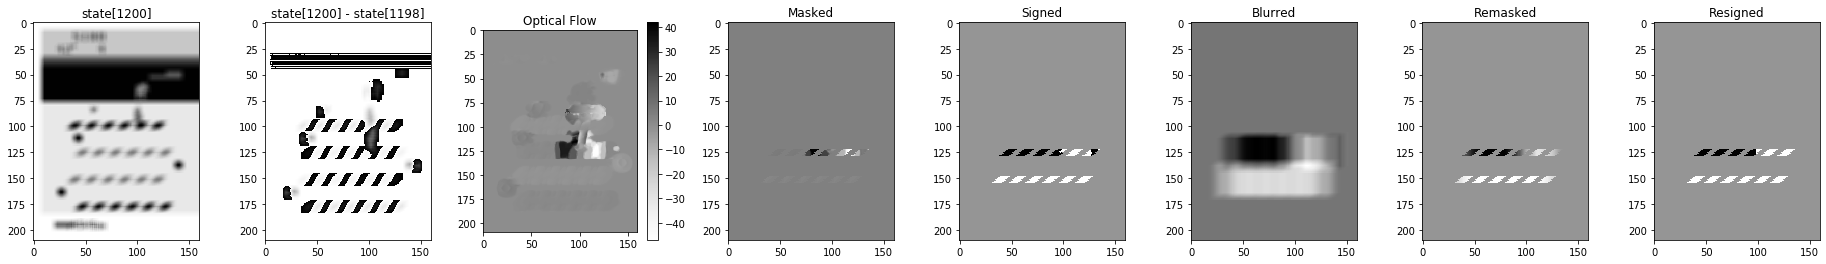

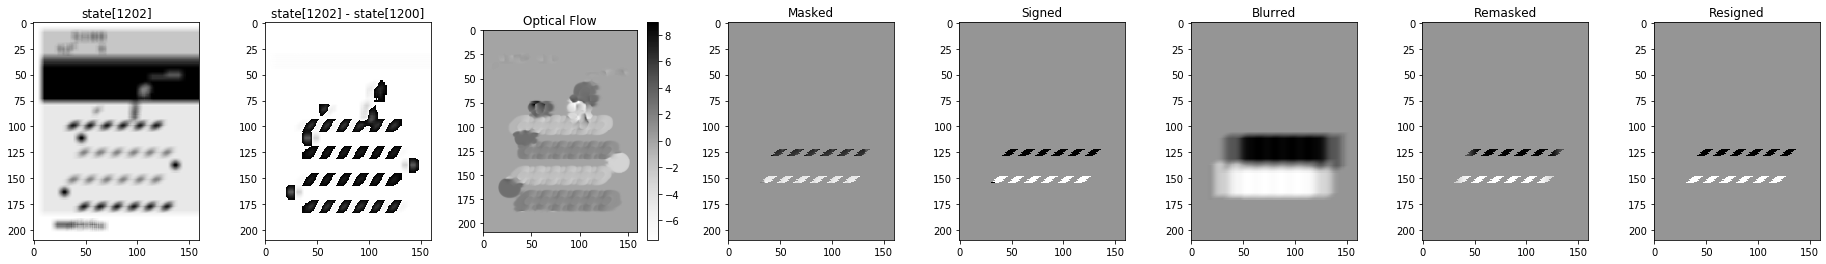

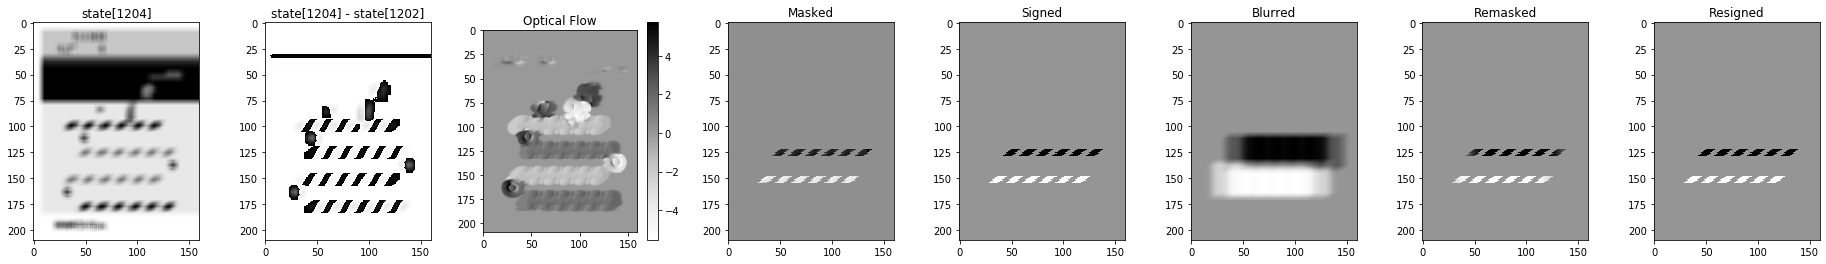

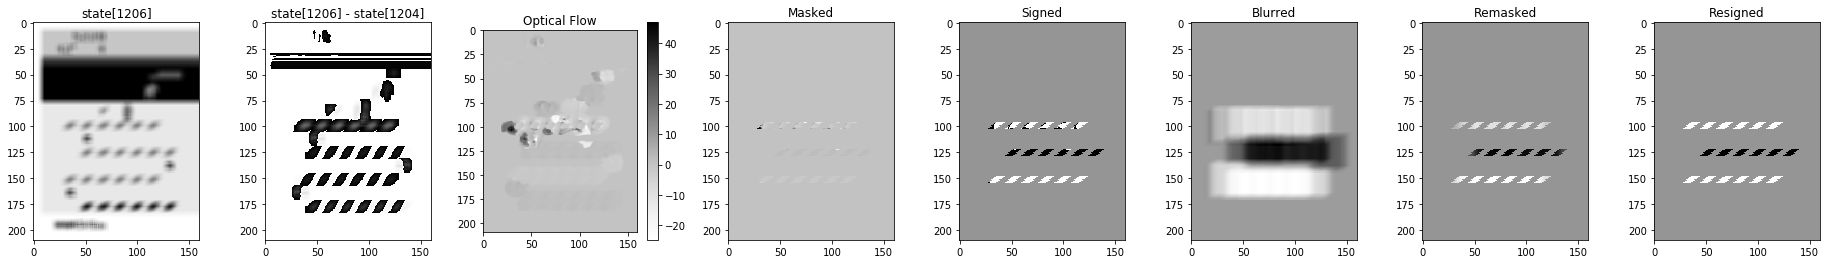

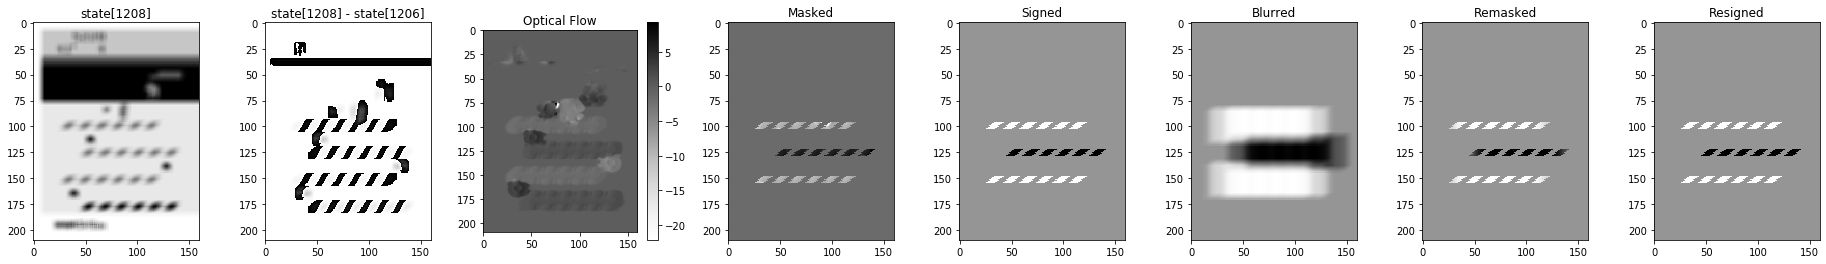

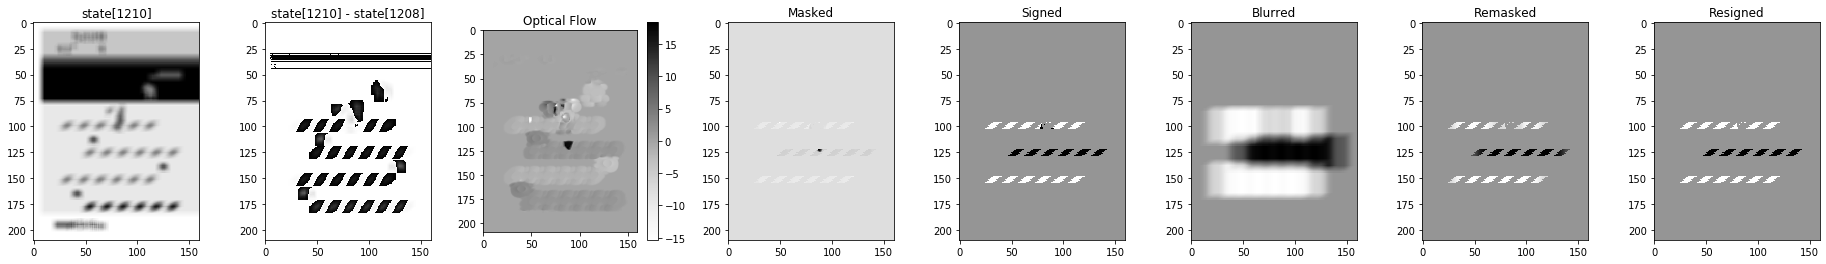

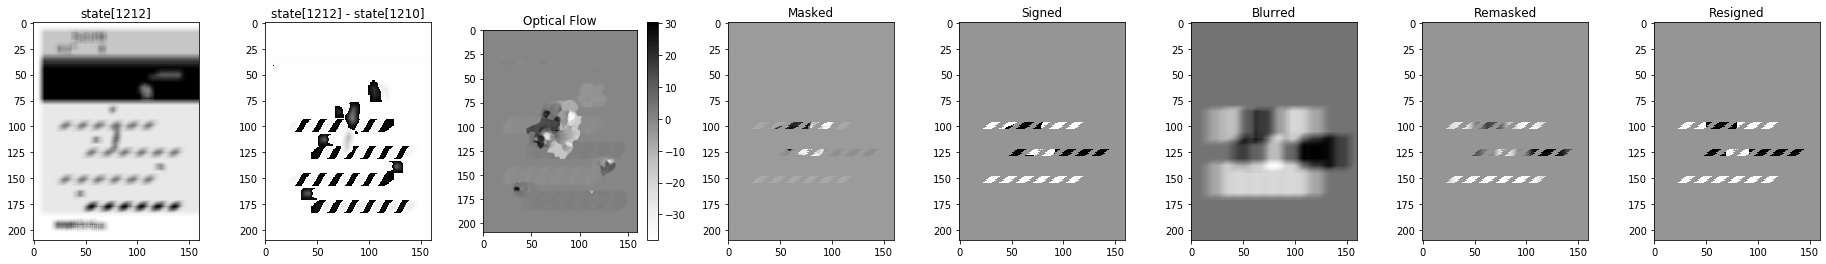

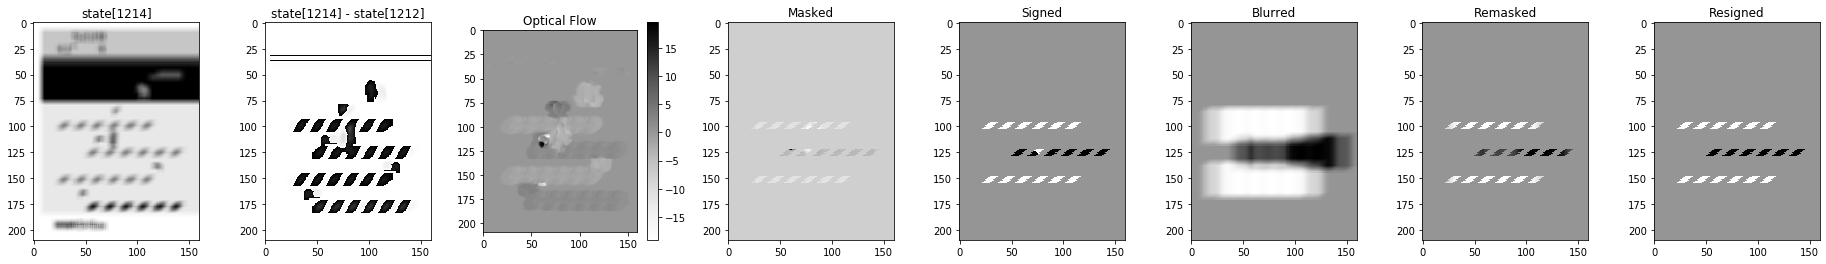

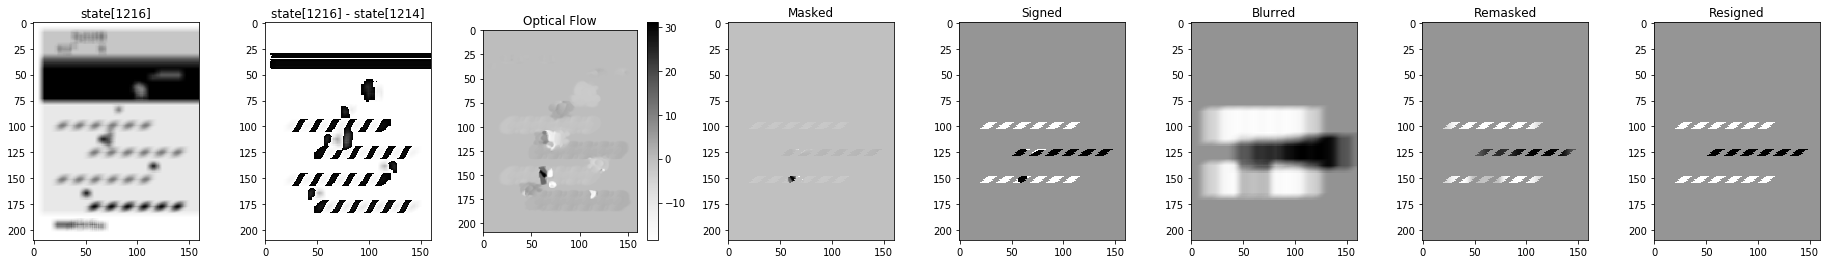

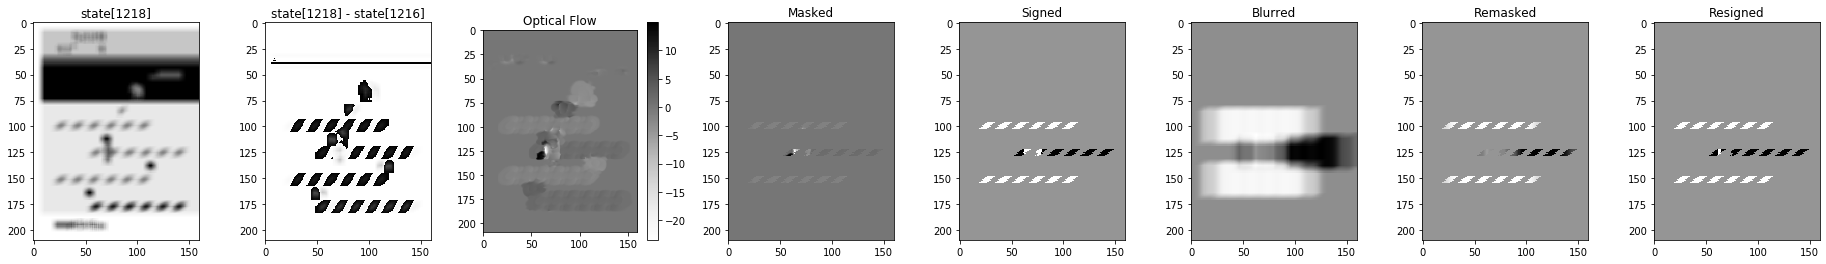

In [99]:
TITLES = ('Pixels', 'Agent', 'Bad Animals', 'Land', 'Good animals', 
          'Visited floes', 'Unvisited floes', 'Bears', 'Igloo')

FARNEBACK_PARAMS = {
    'pyr_scale': 0.5,
    'levels': 7,
    'winsize': 3, # 11,
    'iterations': 3, # 7,
    'poly_n': 7,
    'poly_sigma': 2.0, # 1.2,
    'flags': 0, # cv2.OPTFLOW_USE_INITIAL_FLOW
}


START_INDEX = 1200
NUM_SAMPLES = 10
MASK_INDEX = 5
AXIS_INDEX = 0
NUM_STEPS = 5

NROWS = 1
NCOLS = 3 + NUM_STEPS
COL_WIDTH = 4
ROW_HEIGHT = 4 
WIDTH_SPACING = 0.5
HEIGHT_SPACING = 0


def plot_step(result, step_index, title):
    ax = plt.subplot(NROWS, NCOLS, 4 + step_index)
    ax.imshow(result, cmap='Greys')        
    ax.set_title(title)
    

for i in range(START_INDEX, START_INDEX + NUM_SAMPLES * 2, 2):
    np_state = preprocess_grayscale_state(states_300_0_gray[i:i + 2].max(0), (7, 7))
    prev_state = preprocess_grayscale_state(states_300_0_gray[i - 2:i].max(0), (7, 7))
    
    figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
    plt.subplots_adjust(wspace=0.2)
    
    state_ax = plt.subplot(NROWS, NCOLS, 1)
    state_ax.imshow(np_state, cmap='Greys')
    state_ax.set_title(f'state[{i}]')
        
    # Plot subtraction between them
    diff_ax = plt.subplot(NROWS, NCOLS, 2)
    diff_ax.imshow(np_state - prev_state, cmap='Greys')
    diff_ax.set_title(f'state[{i}] - state[{i - 2}]')

    
    flow = cv2.calcOpticalFlowFarneback(prev_state, np_state, None, **FARNEBACK_PARAMS)
#     flow[np.abs(flow) < FLOW_TOLERANCE] = 0
    axis_flow = flow[:,:,AXIS_INDEX]
    normalizer = matplotlib.colors.Normalize(np.min(axis_flow), np.max(axis_flow))

    flow_ax = plt.subplot(NROWS, NCOLS, 3)
    flow_res = flow_ax.imshow(axis_flow, cmap='Greys', norm=normalizer)
    figure.colorbar(flow_res, ax=flow_ax)
    flow_ax.set_title(f'Optical Flow')
    
    color_np_state = combine_color_by_gray(states_300_0_gray, states_300_0_color, i)
    
    masks = torch_masker_env.masker(torch.tensor(color_np_state, dtype=torch.float, device=args.device)).cpu().numpy()
    
    masked_flow = np.multiply(axis_flow, masks[MASK_INDEX])
    step_index = 0
    plot_step(masked_flow, step_index, 'Masked')
    
    signed_flow = np.sign(masked_flow)
    step_index = 1
    plot_step(signed_flow, step_index, 'Signed')
    
    blurred_flow = cv2.blur(signed_flow, (33, 33))
    step_index = 2
    plot_step(blurred_flow, step_index, 'Blurred')
    
    remasked_flow = np.multiply(blurred_flow, masks[MASK_INDEX])
    step_index = 3
    plot_step(remasked_flow, step_index, 'Remasked')
    
    resigned_flow = np.sign(remasked_flow)
    step_index = 4
    plot_step(resigned_flow, step_index, 'Resigned')

#         signed_flow = (np.sign(masked_flow) * 127 + 127).astype(np.uint8)
#         blurred_flow = cv2.medianBlur(signed_flow, 7)
# #         remasked_flow = np.multiply(blurred_flow, masks[mask_index])
# #         blurred_flow[np.logical_not(masks[mask_index])] = 127
# #         resigned_flow = np.sign(remasked_flow)
    
    
    plt.show()
    

    

# Tiling-related experiments

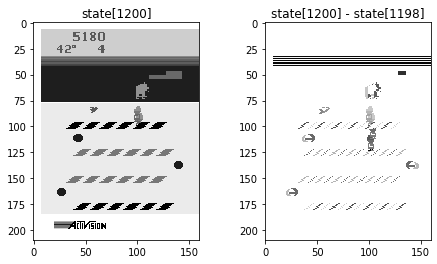

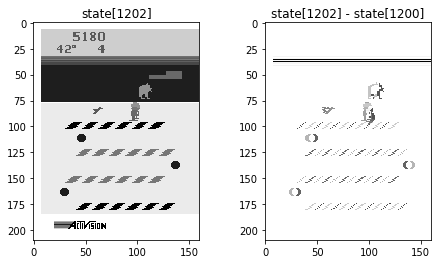

In [97]:
TITLES = ('Pixels', 'Agent', 'Bad Animals', 'Land', 'Good animals', 
          'Visited floes', 'Unvisited floes', 'Bears', 'Igloo')


START_INDEX = 1200
NUM_SAMPLES = 2
MASK_INDEX = 5
AXIS_INDEX = 0
NUM_STEPS = 5
MAX_SHIFT = 7

NROWS = 1
NCOLS = 3 + NUM_STEPS
COL_WIDTH = 4
ROW_HEIGHT = 4 
WIDTH_SPACING = 0.5
HEIGHT_SPACING = 0


def plot_step(result, step_index, title):
    ax = plt.subplot(NROWS, NCOLS, 4 + step_index)
    ax.imshow(result, cmap='Greys')        
    ax.set_title(title)
    
    
def build_slices(shift):
    if shift > 0:
        src_slice = slice(None, -shift)
        dst_slice = slice(shift, None)
        zero_slice = slice(None, shift)

    elif shift < 0:
        src_slice = slice(-shift, None)
        dst_slice = slice(None, shift)
        zero_slice = slice(shift, None)
    
    else:
        src_slice = slice(None, None)
        dst_slice = slice(None, None)
        zero_slice = slice(0, 0)
    
    return src_slice, dst_slice, zero_slice


def shift_masks(mask_or_masks, x_shift=0, y_shift=0):
    mask_or_masks_copy = mask_or_masks.copy()
    x_src_slice, x_dst_slice, x_zero_slice = build_slices(x_shift)
    y_src_slice, y_dst_slice, y_zero_slice = build_slices(y_shift)
    # single mask
    if len(mask_or_masks.shape) == 2:
        mask_or_masks_copy[y_dst_slice, x_dst_slice] = mask_or_masks_copy[y_src_slice, x_src_slice]
        mask_or_masks_copy[y_zero_slice] = 0
        mask_or_masks_copy[:, x_zero_slice] = 0
    
    # multiple masks    
    else:
        mask_or_masks_copy[:, y_dst_slice, x_dst_slice] = mask_or_masks_copy[:, y_src_slice, x_src_slice]
        mask_or_masks_copy[:, y_zero_slice] = 0
        mask_or_masks_copy[:, :, x_zero_slice] = 0
        
    return mask_or_masks_copy


for i in range(START_INDEX, START_INDEX + NUM_SAMPLES * 2, 2):
#     np_state = preprocess_grayscale_state(states_300_0_gray[i:i + 2].max(0), (7, 7))
#     prev_state = preprocess_grayscale_state(states_300_0_gray[i - 2:i].max(0), (7, 7))
    np_state = states_300_0_gray[i:i + 2].max(0)
    prev_state = states_300_0_gray[i - 2:i].max(0)
    
    figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
    plt.subplots_adjust(wspace=0.2)
    
    state_ax = plt.subplot(NROWS, NCOLS, 1)
    state_ax.imshow(np_state, cmap='Greys')
    state_ax.set_title(f'state[{i}]')
        
    # Plot subtraction between them
    diff_ax = plt.subplot(NROWS, NCOLS, 2)
    diff_ax.imshow(np_state - prev_state, cmap='Greys')
    diff_ax.set_title(f'state[{i}] - state[{i - 2}]')

    color_np_state = combine_color_by_gray(states_300_0_gray, states_300_0_color, i)
    color_prev_state = combine_color_by_gray(states_300_0_gray, states_300_0_color, i - 2)
    
    masks = torch_masker_env.masker(torch.tensor(color_np_state, dtype=torch.float, device=args.device)).cpu().numpy()
    prev_masks = torch_masker_env.masker(torch.tensor(color_prev_state, dtype=torch.float, device=args.device)).cpu().numpy()
    
#     masked_flow = np.multiply(axis_flow, masks[MASK_INDEX])
#     step_index = 0
#     plot_step(masked_flow, step_index, 'Masked')
    
#     signed_flow = np.sign(masked_flow)
#     step_index = 1
#     plot_step(signed_flow, step_index, 'Signed')
    
#     blurred_flow = cv2.blur(signed_flow, (33, 33))
#     step_index = 2
#     plot_step(blurred_flow, step_index, 'Blurred')
    
#     remasked_flow = np.multiply(blurred_flow, masks[MASK_INDEX])
#     step_index = 3
#     plot_step(remasked_flow, step_index, 'Remasked')
    
#     resigned_flow = np.sign(remasked_flow)
#     step_index = 4
#     plot_step(resigned_flow, step_index, 'Resigned')

#         signed_flow = (np.sign(masked_flow) * 127 + 127).astype(np.uint8)
#         blurred_flow = cv2.medianBlur(signed_flow, 7)
# #         remasked_flow = np.multiply(blurred_flow, masks[mask_index])
# #         blurred_flow[np.logical_not(masks[mask_index])] = 127
# #         resigned_flow = np.sign(remasked_flow)
    
    
    plt.show()
    

    

In [98]:
all_shifts = list(itertools.product(range(-MAX_SHIFT + 1, MAX_SHIFT), range(-MAX_SHIFT + 1, MAX_SHIFT)))
all_shifted_masks = np.stack([[shift_masks(prev_masks[i], x_shift, y_shift)  
                              for x_shift, y_shift in all_shifts]
                              for i in range(masks.shape[0])])

sum_per_shift_per_channel = np.multiply(all_shifted_masks, np.expand_dims(masks, 1)).sum(3).sum(2)
mask_sums = masks.sum(2).sum(1)
for i, max_idx in enumerate(sum_per_shift_per_channel.argmax(1)):
    if mask_sums[i] > 0:
        out = f'For {TITLES[i + 1]}, the maximal overlapping shift is {all_shifts[max_idx]}'
        out += f' with {sum_per_shift_per_channel[i][max_idx] / mask_sums[i] * 100:.2f}% overlap'
        print(out)

For Agent, the maximal overlapping shift is (-3, -4) with 77.78% overlap
For Bad Animals, the maximal overlapping shift is (3, 0) with 74.88% overlap
For Land, the maximal overlapping shift is (0, 0) with 98.88% overlap
For Good animals, the maximal overlapping shift is (3, 0) with 91.23% overlap
For Visited floes, the maximal overlapping shift is (-1, 0) with 87.50% overlap
For Unvisited floes, the maximal overlapping shift is (-1, 0) with 87.50% overlap
For Igloo, the maximal overlapping shift is (0, 0) with 100.00% overlap


### Use random frame samples to test out background subtraction

In [ ]:
state_0, done = env.reset(), False

In [ ]:
plt.imshow(state_0[3].cpu().numpy(), cmap='Greys')

In [ ]:
s_0_np = state_0[3].cpu().numpy()

In [ ]:
plt.imshow(s_0_np[4:12, :], cmap='Greys')

In [ ]:
doctored_s_0_np = np.copy(s_0_np)
doctored_s_0_np[4:12,4:] = doctored_s_0_np[6,10]
doctored_s_0_np[16:31,4:] = doctored_s_0_np[20,10]
doctored_s_0_np[31:74,4:] = doctored_s_0_np[33,10]
plt.imshow(doctored_s_0_np, cmap='Greys')

## Let's try using this doctored state for the background

In [ ]:
NROWS = 1
NCOLS = 5
COL_WIDTH = 4
ROW_HEIGHT = 4 
WIDTH_SPACING = 0.5
HEIGHT_SPACING = 0

NUM_BACKGROUND_REPS = 100
background_sub = cv2.createBackgroundSubtractorMOG2(varThreshold=64, detectShadows=False)

NAIVE_THRESHOLD = 0.1

# TODO: play around with parameters (history, varThreshold, detectShaowdws, ...)

for _ in range(NUM_BACKGROUND_REPS):
    background_sub.apply(doctored_s_0_np * 255)

        
val_mem = ReplayMemory(args, args.evaluation_size)
done = True
for step in range(100):
    if done:
        print('Resetting env')
        state, done = env.reset(), False

    np_state = state.cpu().numpy()

    figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
    plt.subplots_adjust(wspace=0.2)

    state_to_plot = 3

    ax = plt.subplot(NROWS, NCOLS, 1)
    ax.imshow(np_state[state_to_plot], cmap='Greys')
    ax.set_title(f'state[{state_to_plot}]')

    background_subtracted = background_sub.apply(np_state[state_to_plot] * 255)
    inferred_background = background_sub.getBackgroundImage()
    naive_foreground = np_state[state_to_plot] - doctored_s_0_np
    
    back_ax = plt.subplot(NROWS, NCOLS, 2)
    back_ax.imshow(inferred_background, cmap='Greys')
    back_ax.set_title(f'Current inferred background')
    
    sub_ax = plt.subplot(NROWS, NCOLS, 3)
    sub_ax.imshow(background_subtracted, cmap='Greys')
    sub_ax.set_title(f'state[{state_to_plot}] without background')
    
    naive_ax = plt.subplot(NROWS, NCOLS, 4)
    naive_res = naive_ax.imshow(naive_foreground, cmap='Greys')
    naive_ax.set_title(f'Naive background subtracting')
    
    tweaked_naive_ax = plt.subplot(NROWS, NCOLS, 5)
    tweaked_naive_ax.imshow(np.abs(naive_foreground) > NAIVE_THRESHOLD, cmap='Greys')
    tweaked_naive_ax.set_title(f'Modified naive background subtracting')

    plt.show()
    
    next_state, _, done = env.step(np.random.randint(0, action_space))
    val_mem.append(state, None, None, done)
    state = next_state

## Trying to combine the two

In [ ]:
NROWS = 1
NCOLS = 4
COL_WIDTH = 4
ROW_HEIGHT = 4 
WIDTH_SPACING = 0.5
HEIGHT_SPACING = 0

NAIVE_THRESHOLD = 0.1
MIN_FRAME_TO_PLOT = 15
    
    
def plot_state(np_state, title=None):
    naive_foreground = np_state[3] - doctored_s_0_np
    naive_foreground_mask = np.abs(naive_foreground) > NAIVE_THRESHOLD
    
    state_figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
    plt.subplots_adjust(wspace=0.2)

    if title is not None:
        plt.suptitle(title)

    for i in range(2, state.shape[0]):
        state_ax = plt.subplot(NROWS, NCOLS, i - 1)
        state_ax.imshow(np_state[i], cmap='gray')
        state_ax.set_title(f'state[{i}]')

    # Plot subtraction between them
    sub_ax = plt.subplot(NROWS, NCOLS, 3)
    sub_ax.imshow(np_state[3] - np_state[2], cmap='gray')
    sub_ax.set_title(f'state[3] - state[2]')

    # Plot naive mask
    mask_ax = plt.subplot(NROWS, NCOLS, 4)
    mask_ax.imshow(naive_foreground_mask, cmap='gray')
    mask_ax.set_title(f'Naive mask')

    plt.show()
    
    
def calc_flow(np_state, farneback_params=FARNEBACK_PARAMS, flow_tolerance=FLOW_TOLERANCE):
    flow_2_3 = cv2.calcOpticalFlowFarneback(np_state[2], np_state[3], None, **farneback_params)
    flow_2_3[np.abs(flow_2_3) < flow_tolerance] = 0
    max_min_max = max(np.abs(np.min(flow_2_3)), np.max(flow_2_3))
    normalizer = matplotlib.colors.Normalize(-max_min_max, max_min_max)
    return flow_2_3, normalizer


# def denoise(img):
#     return cv2.fastNlMeansDenoising((img * 255).astype(np.uint8)) #,
#                                    # h=3, templateWindowSize=3, searchWindowSize=11)
def make_blur_func(kernel_size):
    def blur_denoise(img, mask):
        return np.multiply(cv2.blur(img, kernel_size), mask)
    
    return blur_denoise

denoise = make_blur_func((13, 9))

MOVEMENT_SUBPLOTS = 3

def plot_flow(flow, mask, normalizer, ax_name='x', denoise_func=denoise, title=None, plot_mask=False):
    n_subplots = MOVEMENT_SUBPLOTS + int(plot_mask)
    figure = plt.figure(figsize=(n_subplots * COL_WIDTH + WIDTH_SPACING + n_subplots, 
                                 NROWS * ROW_HEIGHT + HEIGHT_SPACING))
    plt.subplots_adjust(wspace=0.4)
    
    if title is not None:
        plt.suptitle(title)

    raw_ax = plt.subplot(1, n_subplots, 1)
    raw_res = raw_ax.imshow(flow, cmap='gray', norm=normalizer)
    figure.colorbar(raw_res, ax=raw_ax)
    raw_ax.set_title(f'2 => 3 {ax_name}-axis')
    
    masked_flow = np.multiply(flow, mask)

    masked_ax = plt.subplot(1, n_subplots, 2)
    masked_res = masked_ax.imshow(masked_flow, cmap='gray', norm=normalizer)
    figure.colorbar(masked_res, ax=masked_ax)
    masked_ax.set_title(f'2 => 3 {ax_name}-axis, masked')

    denoised_flow = denoise_func(flow, mask)
    
    denoised_masked_ax = plt.subplot(1, n_subplots, 3)
    denoised_res = denoised_masked_ax.imshow(denoised_flow, cmap='gray', norm=normalizer)
    figure.colorbar(denoised_res, ax=denoised_masked_ax)
    denoised_masked_ax.set_title(f'2 => 3 {ax_name}-axis, denoised & masked')

    if plot_mask:
        mask_ax = plt.subplot(1, n_subplots, 4)
        mask_res = mask_ax.imshow(mask.astype(np.uint8), cmap='gray') #, norm=normalizer)
        figure.colorbar(mask_res, ax=mask_ax)
        mask_ax.set_title(f'Raw foreground mask')
    
    plt.show() 

In [ ]:
np_states = []
x_flows = []
y_flows = []
fg_masks = []
normalizers = []

val_mem = ReplayMemory(args, args.evaluation_size)
done = True
for frame in range(40):
    
    if done:
        state, done = env.reset(), False

    np_state = state.cpu().numpy()
    naive_foreground = np_state[3] - doctored_s_0_np
    naive_foreground_mask = np.abs(naive_foreground) > NAIVE_THRESHOLD
    
    if frame >= MIN_FRAME_TO_PLOT:
        plot_state(np_state, title=f'State #{frame}')
        np_states.append(np_state)
        
        flow, normalizer = calc_flow(np_state)
        x_flows.append(flow[:,:,0])
        y_flows.append(flow[:,:,1])
        fg_masks.append(naive_foreground_mask)
        normalizers.append(normalizer)
        
        # Figure for X-axis movement
        plot_flow(flow[:,:,0], naive_foreground_mask, normalizer, 'x')
        
        # Figure for Y-axis movement
        plot_flow(flow[:,:,1], naive_foreground_mask, normalizer, 'y')
        
    next_state, _, done = env.step(np.random.randint(0, action_space))
    val_mem.append(state, None, None, done)
    state = next_state

In [ ]:
i = 14

# mask = np.ones_like(fg_masks[i])
# mask = fg_masks[i]


def range_remap(original, modified):
    """Remap an np.array linearly from the range of the modified back to the range of the original.
    If the original is over the range [a, b] and the modified is over the range [c, d],
    the function is f(x) = a + (b - a)(x - c)/(d - c)
    """
    orig_min = np.min(original)
    orig_max = np.max(original)
    mod_min = np.min(modified)
    mod_max = np.max(modified)
    
    return (modified - mod_min) * (orig_max - orig_min) / (mod_max - mod_min) + orig_min
    

def make_blur_func(kernel_size):
    def blur_denoise(img, mask):
        return np.multiply(range_remap(img, cv2.blur(img, kernel_size)), mask)
    
    return blur_denoise

plot_state(np_states[i])

k = (9, 9)
plot_flow(x_flows[i], fg_masks[i], normalizers[i], denoise_func=make_blur_func(k), 
          title=f'{k[0]}x{k[1]} blur', plot_mask=True)

k = (13, 13)
plot_flow(x_flows[i], fg_masks[i], normalizers[i], denoise_func=make_blur_func(k), 
          title=f'{k[0]}x{k[1]} blur', plot_mask=True)

k = (17, 17)
plot_flow(x_flows[i], fg_masks[i], normalizers[i], denoise_func=make_blur_func(k), 
          title=f'{k[0]}x{k[1]} blur', plot_mask=True)

k = (13, 9)
plot_flow(x_flows[i], fg_masks[i], normalizers[i], denoise_func=make_blur_func(k), 
          title=f'{k[0]}x{k[1]} blur', plot_mask=True)

k = (17, 9)
plot_flow(x_flows[i], fg_masks[i], normalizers[i], denoise_func=make_blur_func(k), 
          title=f'{k[0]}x{k[1]} blur', plot_mask=True)


## First question -- let's confirm that the value affects the flow

In [ ]:
bg_color = 0.1254902

for increment in np.arange(0, 0.5, 0.1):
    state_copy = np.copy(np_states[i])
    state_copy_slice = state_copy[:,35:45,5:]
    state_copy_slice[state_copy_slice != bg_color] = state_copy_slice[state_copy_slice != bg_color] + increment 

    plot_state(state_copy, title=f'Increment of {increment}')
    
    flow, normalizer = calc_flow(state_copy)
    naive_foreground = state_copy[3] - doctored_s_0_np
    naive_foreground_mask = np.abs(naive_foreground) > NAIVE_THRESHOLD
    plot_flow(flow[:,:,0], naive_foreground_mask, normalizer, 'x')
    
    
state_copy = np.copy(np_states[i])
state_copy[2] = transform(state_copy[2])
state_copy[3] = transform(state_copy[3])
plot_state(state_copy, title=f'Transformed')

flow, normalizer = calc_flow(state_copy)
naive_foreground = state_copy[3] - doctored_s_0_np
naive_foreground_mask = np.abs(naive_foreground) > NAIVE_THRESHOLD
plot_flow(flow[:,:,0], naive_foreground_mask, normalizer, 'x')


In [ ]:
c = np.copy(np_states[i])
plt.imshow(c[3], cmap='gray'); plt.show()
c[3,main_range_rows[0]:main_range_rows[1],main_range_cols[0]:main_range_cols[1]][~np.isclose(c[3,main_range_rows[0]:main_range_rows[1],main_range_cols[0]:main_range_cols[1]], bg_color, atol=1e-4)] = fg_color
plt.imshow(c[3], cmap='gray'); plt.show()

## Let's play around with how the flow is being calculated

In [ ]:
np.sum((0.4 < main_area) & (0.7 > main_area)), np.sum(np.isclose(main_area, 0.55, atol=0.15))

In [ ]:
i = 14
bg_color = 0.1254902
fg_color = 0.8
main_range_rows = (31, 74)
main_range_cols = (4, 84)
muted_fg_min = 0.4
muted_fg_max = 0.7
muted_fg_half_range = (muted_fg_max - muted_fg_min) / 2

def transform(x, inc=0.3):
#     t = (np.abs(x - doctored_s_0_np) > 0.05).astype(np.uint8)
#     t = np.abs(x - doctored_s_0_np)
    c = np.copy(x)
    c[main_range_rows[0]:main_range_rows[1],main_range_cols[0]:main_range_cols[1]][
        np.isclose(c[main_range_rows[0]:main_range_rows[1],main_range_cols[0]:main_range_cols[1]], 
                   muted_fg_min + muted_fg_half_range, atol=muted_fg_half_range)
    ] += inc
    print(np.min(c), np.max(c))
    return c


norm = matplotlib.colors.Normalize(0, 1)

plt.imshow(np_states[i][3], cmap='Greys', norm=norm)
plt.show()

# Whole thing
main_area = np_states[i][3][main_range_rows[0]:main_range_rows[1],main_range_cols[0]:main_range_cols[1]]
plt.imshow(main_area, cmap='Greys', norm=norm)
plt.show()

plt.hist(np.ravel(main_area),bins=30)
plt.show()

# Whole thing, messing around with ranges
main_area_copy = np.copy(main_area)
main_area_copy[(0.4 < main_area_copy) & (0.7 > main_area)] += 0.3

plt.imshow(main_area_copy, cmap='Greys', norm=norm)
plt.show()

plt.hist(np.ravel(main_area_copy),bins=30)
plt.show()


plt.imshow(np_states[i][3][main_range_rows[0]:main_range_rows[1],main_range_cols[0]:main_range_cols[1]], 
           cmap='Greys', norm=norm)
plt.show()

plt.hist(np.ravel(np_states[i][3][main_range_rows[0]:main_range_rows[1],main_range_cols[0]:main_range_cols[1]]),
        bins=30)
plt.show()

# Top two rows
top_two_rows = np.copy(np_states[i][3][main_range_rows[0]:main_range_rows[1] - 22,main_range_cols[0]:main_range_cols[1]])
top_two_rows[top_two_rows < 0.4] = 0

plt.imshow(top_two_rows,cmap='Greys', norm=norm)
plt.show()

plt.hist(np.ravel(top_two_rows), bins=30)
plt.show()

# Bottom two rows
bottom_two_rows = np_states[i][3][main_range_rows[0] + 22:main_range_rows[1],main_range_cols[0]:main_range_cols[1]]

plt.imshow(bottom_two_rows, cmap='Greys', norm=norm)
plt.show()

plt.hist(bottom_two_rows, bins=30)
plt.show()

c = np.copy(np_states[i][3])

c[main_range_rows[0]:main_range_rows[1],main_range_cols[0]:main_range_cols[1]][~np.isclose(c[main_range_rows[0]:main_range_rows[1],main_range_cols[0]:main_range_cols[1]], bg_color, atol=1e-4)] = fg_color

# sub_c = c[main_range_rows[0]:main_range_rows[1],main_range_cols[0]:main_range_cols[1]]
# sub_c[~np.isclose(sub_c, bg_color, atol=1e-4)] = fg_color
# c[main_range_rows[0]:main_range_rows[1],main_range_cols[0]:main_range_cols[1]] = sub_c
plt.imshow(c, cmap='Greys', norm=norm)
plt.show()

plt.imshow(transform(np_states[i][3]), cmap='Greys', norm=norm)
plt.show()

In [ ]:
def non_average_blur_x(img, mask):
    return np.multiply(cv2.boxFilter(img, -1, (7, 3), normalize=False), mask)

def non_average_blur_y(img, mask):
    return np.multiply(cv2.boxFilter(img, -1, (3, 3), normalize=False), mask)


def to_uint8(x):
    return (x * 255).astype(np.uint8)

def modified_calc_flow(np_state, increment, farneback_params=FARNEBACK_PARAMS, flow_tolerance=FLOW_TOLERANCE):
    s_2_fg_mask = transform(np_state[2], increment)
    s_3_fg_mask = transform(np_state[3], increment)
#     s_2_fg_mask = to_uint8(np_state[2])
#     s_3_fg_mask = to_uint8(np_state[3])
    
    flow_2_3 = cv2.calcOpticalFlowFarneback(s_2_fg_mask, s_3_fg_mask, None, **farneback_params)
    flow_2_3[np.abs(flow_2_3) < flow_tolerance] = 0

    print(flow_2_3.shape, np.min(flow_2_3), np.max(flow_2_3))

    max_min_max = max(np.abs(np.min(flow_2_3)), np.max(flow_2_3))
    normalizer = matplotlib.colors.Normalize(-max_min_max, max_min_max)
    return flow_2_3, normalizer

In [ ]:


bg_color = 0.1254902

for increment in np.arange(0, 0.5, 0.1):
#     state_copy = np.copy(np_states[i])
#     state_copy_slice = state_copy[:,35:45,5:]
#     state_copy_slice[state_copy_slice != bg_color] = state_copy_slice[state_copy_slice != bg_color] + increment 

    plot_state(state_copy, title=f'Increment of {increment}')
    
    flow, normalizer = modified_calc_flow(state_copy, increment)
    naive_foreground = state_copy[3] - doctored_s_0_np
    naive_foreground_mask = np.abs(naive_foreground) > NAIVE_THRESHOLD
    plot_flow(flow[:,:,0], naive_foreground_mask, normalizer, 'x', denoise_func=non_average_blur_x)


## Trying the above but on a pile of states

In [ ]:
for frame, np_state in enumerate(np_states):
    naive_foreground = np_state[3] - doctored_s_0_np
    naive_foreground_mask = np.abs(naive_foreground) > NAIVE_THRESHOLD
    
    if frame >= MIN_FRAME_TO_PLOT:
        plot_state(np_state, title=f'State #{frame}')
        
        flow, normalizer = modified_calc_flow(np_state, 0.25)
        
        # Figure for X-axis movement
        plot_flow(flow[:,:,0], naive_foreground_mask, normalizer, 'x', denoise_func=non_average_blur_x)
        
        # Figure for Y-axis movement
        plot_flow(flow[:,:,1], naive_foreground_mask, normalizer, 'y', denoise_func=non_average_blur_y)


## Messing around with different optical flows on real data

In [ ]:
import sys
pyflow_folder = '/home/gd1279/projects/pyflow'
if pyflow_folder not in sys.path: sys.path.append(pyflow_folder)
import pyflow
import pyoptflow

In [ ]:
def load_saved_states(seed, num=0, name='baseline-rainbow', color=False):
    state_type = color and 'color' or 'gray'
    path_glob = os.path.join('../results', f'{name}-{seed}', 'evaluation/states', f'*{num}-{state_type}.pickle')
    path = glob.glob(path_glob)[0]
    
    with open(path, 'rb') as pickle_file:
        return pickle.load(pickle_file)

    
states_300_0_gray = load_saved_states(300)
print(states_300_0_gray.shape)

In [ ]:
FARNEBACK_PARAMS = dict(
    pyr_scale=0.5,
    levels=3,
    winsize=5, # 15,
    iterations=7, # 3,
    poly_n=3, # 5,
    poly_sigma=0.8, # 1.2,
    flags=0, # cv2.OPTFLOW_USE_INITIAL_FLOW
)

FARNEBACK_FLOW_TOLERANCE = 1e-5

def resize_func(img, size=(84, 84)):
    return cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)

def flow_farneback(x_0, x_1, **kwargs):
    params = copy.copy(FARNEBACK_PARAMS)
    for key in kwargs:
        params[key] = kwargs[key]
            
    flow = cv2.calcOpticalFlowFarneback(x_0.astype(np.float) / 255, 
                                        x_1.astype(np.float) / 255, 
                                        None, **params)
    return flow[:,:,0], flow[:,:,1]


PYFLOW_PARAMS = dict(
    alpha=0.008, # 0.012,
    ratio=0.75,
    minWidth=5, # 20,
    nOuterFPIterations=7,
    nInnerFPIterations=1,
    nSORIterations=30,
    colType=1,  # 0 or default:RGB, 1:GRAY (but pass gray image with shape (h,w,1))
)

PYFLOW_FLOW_TOLERANCE = 0.75

def flow_pyflow(x_0, x_1, **kwargs):
    params = copy.copy(PYFLOW_PARAMS)
    for key in kwargs:
        params[key] = kwargs[key]
            
    x_flow, y_flow, _ =  pyflow.coarse2fine_flow(np.expand_dims(x_0.astype(np.float) / 255, 2), 
                                                 np.expand_dims(x_1.astype(np.float) / 255, 2), 
                                                 **params)
    return x_flow, y_flow


PYOPTFLOW_PARAMS = dict(
    alpha=0.5, # 1.0
    Niter=100,
)


def flow_pyoptflow(x_0, x_1, **kwargs):
    params = copy.copy(PYOPTFLOW_PARAMS)
    for key in kwargs:
        params[key] = kwargs[key]
            
    return pyoptflow.HornSchunck(x_0.astype(np.float) / 255, x_1.astype(np.float) / 255, **params)


PYOPTFLOW_FLOW_TOLERANCE = 0.1

FLOW_METHODS = (flow_farneback, flow_pyflow, flow_pyoptflow)
FLOW_NAMES = ('Farneback', 'pyflow', 'pyoptflow')
FLOW_TOLERANCES = (FARNEBACK_FLOW_TOLERANCE, PYFLOW_FLOW_TOLERANCE, PYOPTFLOW_FLOW_TOLERANCE)

FLOW_CONFIGS = (FLOW_METHODS, FLOW_NAMES, FLOW_TOLERANCES)


def plot_with_flows(frame_indices, flow_configs):
    NROWS = 1
    NCOLS = 3 + 2 * len(FLOW_METHODS)
    COL_WIDTH = 4
    ROW_HEIGHT = 4 
    WIDTH_SPACING = 0.5
    HEIGHT_SPACING = 0
    
    for frame_index in frame_indices:
        figure = plt.figure(figsize=(NCOLS * COL_WIDTH + WIDTH_SPACING, NROWS * ROW_HEIGHT + HEIGHT_SPACING))
        plt.subplots_adjust(wspace=0.2)

        frame, next_frame = resize_func(states_300_0_gray[frame_index]), resize_func(states_300_0_gray[frame_index + 1])

        for i, img in enumerate((frame, next_frame)):
            ax = plt.subplot(NROWS, NCOLS, i + 1)
            ax.imshow(img, cmap='gray')
            ax.set_title(f'Frame {frame_index + i}')

        # Plot subtraction between them
        ax = plt.subplot(NROWS, NCOLS, 3)
        ax.imshow(next_frame - frame, cmap='Greys')
        ax.set_title(f'$\\Delta$')

        for i, (flow_func, name, tol) in enumerate(zip(*flow_configs)):
            flow_x, flow_y = flow_func(frame, next_frame)
            for flow in flow_x, flow_y:
                flow[np.abs(flow) < tol] = 0

            x_normalizer = matplotlib.colors.Normalize(np.min(flow_x), np.max(flow_x))
            y_normalizer = matplotlib.colors.Normalize(np.min(flow_y), np.max(flow_y))

            x_ax = plt.subplot(NROWS, NCOLS, 4 + (i * 2))
            x_res = x_ax.imshow(flow_x, cmap='gray', norm=x_normalizer)
            figure.colorbar(x_res, ax=x_ax)
            x_ax.set_title(f'{name} x-flow')

            y_ax = plt.subplot(NROWS, NCOLS, 5 + (i * 2))
            y_res = y_ax.imshow(flow_y, cmap='gray', norm=y_normalizer)
            figure.colorbar(y_res, ax=y_ax)
            y_ax.set_title(f'{name} y-flow')

        plt.show()

In [ ]:
plot_with_flows(range(150, 160), # range(0, 2300, 50)
                FLOW_CONFIGS)

## Trying some different parameter values

### PyOptFlow with different alpha values

In [ ]:
alpha_values = [0.01, 0.05, 0.1, 0.25]

FLOW_METHODS = [lambda x_0, x_1: flow_pyoptflow(x_0, x_1, alpha=alpha)
                for alpha in alpha_values]
FLOW_NAMES = [f'Alpha {alpha}' for alpha in alpha_values]
FLOW_TOLERANCES = [PYOPTFLOW_TOLERANCE] * 4

FLOW_CONFIGS = (FLOW_METHODS, FLOW_NAMES, FLOW_TOLERANCES)

plot_with_flows(range(155, 158), # range(0, 2300, 50)
                FLOW_CONFIGS)

### PyOptFlow with different tolerances

In [ ]:
tolerances = [0.1, 0.15, 0.2, 0.25]

FLOW_METHODS = [lambda x_0, x_1: flow_pyoptflow(x_0, x_1, alpha=0.5)] * len(tolerances)
FLOW_NAMES = [f'Tol {tol}' for tol in tolerances]
FLOW_TOLERANCES = tolerances

FLOW_CONFIGS = (FLOW_METHODS, FLOW_NAMES, FLOW_TOLERANCES)

plot_with_flows(range(135, 138), # range(0, 2300, 50)
                FLOW_CONFIGS)

### PyFlow 
has the following parameters by default:
```python
PYFLOW_PARAMS = dict(
    alpha=0.012,
    ratio=0.75,
    minWidth=20,
    nOuterFPIterations=7,
    nInnerFPIterations=1,
    nSORIterations=30,
    colType=1,  # 0 or default:RGB, 1:GRAY (but pass gray image with shape (h,w,1))
)
```

In [ ]:
param_name = 'alpha'
param_values = [.006, .007, .008, .009]


FLOW_METHODS = [lambda x_0, x_1, val=param_value: flow_pyflow(x_0, x_1, **{param_name: val})
                for param_value in param_values]
FLOW_NAMES = [f'{param_name}={param_value}' for param_value in param_values]
FLOW_TOLERANCES = [PYFLOW_FLOW_TOLERANCE] * 4

FLOW_CONFIGS = (FLOW_METHODS, FLOW_NAMES, FLOW_TOLERANCES)

plot_with_flows(range(155, 158), # range(0, 2300, 50)
                FLOW_CONFIGS)

In [ ]:
param_name = 'minWidth'
param_values = [5, 10, 25, 50]

FLOW_METHODS = [lambda x_0, x_1, val=param_value: flow_pyflow(x_0, x_1, **{'alpha': 0.008, param_name: val})
                for param_value in param_values]
FLOW_NAMES = [f'{param_name}={param_value}' for param_value in param_values]
FLOW_TOLERANCES = [PYFLOW_FLOW_TOLERANCE] * 4

FLOW_CONFIGS = (FLOW_METHODS, FLOW_NAMES, FLOW_TOLERANCES)

plot_with_flows(range(155, 158), # range(0, 2300, 50)
                FLOW_CONFIGS)

In [ ]:
param_name = 'ratio'
param_values = [0.6, 0.7, 0.8, 0.9]

FLOW_METHODS = [lambda x_0, x_1, val=param_value: flow_pyflow(x_0, x_1, **{'alpha': 0.008, 'minWidth': 5, param_name: val})
                for param_value in param_values]
FLOW_NAMES = [f'{param_name}={param_value}' for param_value in param_values]
FLOW_TOLERANCES = [PYFLOW_FLOW_TOLERANCE] * 4

FLOW_CONFIGS = (FLOW_METHODS, FLOW_NAMES, FLOW_TOLERANCES)

plot_with_flows(range(155, 158), # range(0, 2300, 50)
                FLOW_CONFIGS)

In [ ]:
tolerances = [0.7, 0.8, 0.9, 1.0]

FLOW_METHODS = [flow_pyflow] * len(tolerances)
FLOW_NAMES = [f'Tol={tol}' for tol in tolerances]
FLOW_TOLERANCES = tolerances

FLOW_CONFIGS = (FLOW_METHODS, FLOW_NAMES, FLOW_TOLERANCES)

plot_with_flows(range(135, 138), # range(0, 2300, 50)
                FLOW_CONFIGS)

### Farneback

Original params:
```python
FARNEBACK_PARAMS = dict(
    pyr_scale=0.5,
    levels=3,
    winsize=5, # 15,
    iterations=7, # 3,
    poly_n=3, # 5,
    poly_sigma=0.8, # 1.2,
    flags=0, # cv2.OPTFLOW_USE_INITIAL_FLOW
)
```

In [ ]:
param_name = 'poly_sigma'
param_values = [0.4, 0.6, 0.8, 1.0]

FLOW_METHODS = [lambda x_0, x_1, val=param_value: flow_farneback(x_0, x_1, **{param_name: val})
                for param_value in param_values]
FLOW_NAMES = [f'{param_name}={param_value}' for param_value in param_values]
FLOW_TOLERANCES = [FARNEBACK_FLOW_TOLERANCE] * 4

FLOW_CONFIGS = (FLOW_METHODS, FLOW_NAMES, FLOW_TOLERANCES)

plot_with_flows(range(135, 138), # range(0, 2300, 50)
                FLOW_CONFIGS)

In [ ]:
for x in zip(*FLOW_CONFIGS):
    print(x)

In [ ]:

# def gauss_blur_denoise(img):
#     return np.multiply(cv2.GaussianBlur(img, (9, 9), 0), mask)

# plot_flow(x_flows[i], fg_masks[i], normalizers[i], denoise_func=gauss_blur_denoise, title='Gaussian blur', plot_mask=True)

# def median_blur_denoise(img):
#     return np.multiply(cv2.medianBlur(to_uint8(img), 11), mask)

# plot_flow(x_flows[i], fg_masks[i], normalizers[i], denoise_func=median_blur_denoise, title='Median blur', plot_mask=True)

# def bilateral_denoise(img):
#     return np.multiply(cv2.bilateralFilter(img, 7, 200, 50), mask)

# plot_flow(x_flows[i], fg_masks[i], normalizers[i], denoise_func=bilateral_denoise, title='Bilateral filter', plot_mask=True)

# def threshold_denoise(img, thresh=1e-4):
#     img_copy = np.copy(img)
#     img_copy[img_copy > thresh] = 1
#     img_copy[img_copy < -thresh] = -1
#     return np.multiply(img_copy, mask)

# plot_flow(x_flows[i], fg_masks[i], normalizers[i], denoise_func=threshold_denoise, title='Threshold', plot_mask=True)